In [1]:
cd ..

/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode


In [2]:
pwd

'/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode'

In [3]:
import os 
import sys
import yaml
import json
from pprint import pprint
from glob import glob
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import pyrender

import pygarment as pyg
import open3d as o3d
import trimesh
import plotly.graph_objects as go
import PIL
from PIL import Image

# basic visualization fucntions

def plot_panel_info(
    ax, panel_name, panel_svg_path_dict, stitch_dict,
    N_SAMPLES: int = 100,
):
    path = panel_svg_path_dict[panel_name][0]
    
    # boundary_points = np.array([path.point(t) for t in np.linspace(0, 1, N_SAMPLES)])
    # boundary_points = np.array([boundary_points.real, boundary_points.imag]).T
        
    # ax.plot(boundary_points[:, 0], boundary_points[:, 1], 'b-')
    ax.set_title(panel_name)
    ax.axis('equal')
    ax.grid(True)

    # Create a color map for different edges
    colors = plt.cm.rainbow(np.linspace(0, 1, len(path)))

    for edge_idx, segment in enumerate(path):
        
        segment_points = np.array([
            [segment.point(t).real, segment.point(t).imag]
            for t in np.linspace(0, 1, N_SAMPLES)
        ])
        
        ax.plot(
            segment_points[:, 0],
            segment_points[:, 1] * -1,
            '-', color=colors[edge_idx]
        )
        
        segment_center = segment.point(0.5)
        segment_center = np.array([segment_center.real, segment_center.imag])
    
        has_stitch = False
    
        for stitch_idx, stitch_edges in stitch_dict.items():
            # print(stitch_idx, stitch_edges)
            for edge_info in stitch_edges:
                if edge_info['edge'] == edge_idx and edge_info['panel'] == panel_name:
                    has_stitch = True
                    ax.text(
                        segment_center[0],
                        -segment_center[1],
                        f"{stitch_idx}\n{edge_info['edge']}",
                        ha='center', va='center'
                    )

        if not has_stitch:
            ax.text(
                segment_center[0],
                -segment_center[1],
                f"no stitch,\n{edge_idx}",
                ha='center', va='center'
            )
            
            
def visualize_meshes_plotly(
    mesh_list, color_list=None,
    vertex_list = None
):
    if not isinstance(mesh_list, list):
        mesh_list = [mesh_list]
    
    final_mesh_list = []
    for mesh in mesh_list:
        if isinstance(mesh, str):
            mesh = trimesh.load(mesh)
        final_mesh_list.append(mesh)
    
    if color_list is None:
        color_list = ['lightgray'] * len(final_mesh_list)
    
    # Create the 3D scatter plot for vertices
    fig = go.Figure(data=[
        go.Mesh3d(
            x=mesh.vertices[:, 0],
            y=mesh.vertices[:, 1],
            z=mesh.vertices[:, 2],
            i=mesh.faces[:, 0],
            j=mesh.faces[:, 1],
            k=mesh.faces[:, 2],
            opacity=0.5,
            facecolor=mesh.visual.face_colors[:, :3] if hasattr(mesh.visual, 'face_colors') else None,
            color=None if hasattr(mesh.visual, 'face_colors') else color
        ) for mesh, color in zip(final_mesh_list, color_list)
    ])
    
    
    if vertex_list is not None:
        fig.add_trace(go.Scatter3d(
            x=vertex_list[:, 0],
            y=vertex_list[:, 1],
            z=vertex_list[:, 2],
            mode='markers',
            marker=dict(
                size=1,
                color='blue',
                opacity=1
            ),
            name='Vertices'
        ))
        
        
    # Update the layout
    fig.update_layout(
        scene=dict(
            aspectmode='data'  # Preserve aspect ratio
        ),
        width=800,
        height=800,
        showlegend=False
    )
    
    # Show the plot
    fig.show()
    
    
def v_id_map(vertices): 
    v_map = [None] * len(vertices) 
    v_map[0] = 0 
    for i in range(1, len(vertices)): 
        if all(vertices[i - 1] == vertices[i]): 
            v_map[i] = v_map[i-1]   
        else: 
            v_map[i] = v_map[i-1] + 1 
    return v_map




PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(PROJECT_ROOT_PATH, "neutral_body/mean_all.obj")
    
default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

print("body vertices", default_body_mesh.vertices.shape)
print("body faces", default_body_mesh.faces.shape)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
body vertices (23751, 3)
body faces (47500, 3)


## Visualize Default Body Setting

## Note

garment_5000_27/random_body/dataset_properties_random_body.yaml 도 고려해야 함

In [4]:
# IDX = 0
# # BODY_TYPE = "random_body"
# BODY_TYPE = "default_body"

# garment_path = sorted(list(filter(
#     os.path.isdir,
#     glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
# )))[IDX]

# garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"

# garment_id = os.path.basename(garment_path)

# SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")

# pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

# panel_svg_path_dict = {
#     panel_name : pattern._draw_a_panel(
#         panel_name, apply_transform=False, fill=True
#     )
#     for panel_name in pattern.panel_order()
# }
# stitch_dict = {
#     i : v for i, v in enumerate(pattern.pattern['stitches'])
# }

# print(stitch_dict)

In [5]:
# tex_image = PIL.Image.open(os.path.join(garment_path, f"{garment_id}_texture.png"))

# with open(os.path.join(garment_path, f"{garment_id}_sim_segmentation.txt"), "r") as f:
#     segmentation = f.readlines()
# print(len(segmentation))


In [6]:
# simulated_garment_mesh = trimesh.load_mesh(
#     os.path.join(garment_path, f"{garment_id}_sim.ply"),
#     process=False
# )
# simulated_garment_mesh.vertices = simulated_garment_mesh.vertices / 100

# texture = trimesh.visual.TextureVisuals(
#     simulated_garment_mesh.visual.uv,
#     image=tex_image
# )
# simulated_garment_mesh.visual = texture

# print("vertices", simulated_garment_mesh.vertices.shape)
# print("faces", simulated_garment_mesh.faces.shape)

# idx_convert_map = v_id_map(simulated_garment_mesh.vertices)

# print("idx_convert_map length", len(idx_convert_map))
# print("idx_convert_map", idx_convert_map)
# print()

# # visualize_meshes_plotly(
# #     [simulated_garment_mesh, default_body_mesh],
# # )

In [7]:

# stitch_vertex_mask_raw = np.array(list(map(
#     # lambda x : True if x.startswith("stitch") else False,
#     lambda x : True if x.startswith("stitch_12") else False,
#     segmentation
# )))
# print(stitch_vertex_mask_raw.shape, stitch_vertex_mask_raw.sum())


# stitch_vertex_mask = np.array(list(map(
#     lambda idx : True if stitch_vertex_mask_raw[idx] else False,
#     idx_convert_map
# )))

# print("stitch_vertex_mask", stitch_vertex_mask.shape, stitch_vertex_mask.sum())


# stitch_vertices = simulated_garment_mesh.vertices[stitch_vertex_mask]

# visualize_meshes_plotly(
#     [
#         simulated_garment_mesh,
#         default_body_mesh
#     ],
#     color_list=["red", "blue"],
#     vertex_list=stitch_vertices
# )

## Visualize Visible Seam Line Annotation Data


In [8]:
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "back", "right", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}


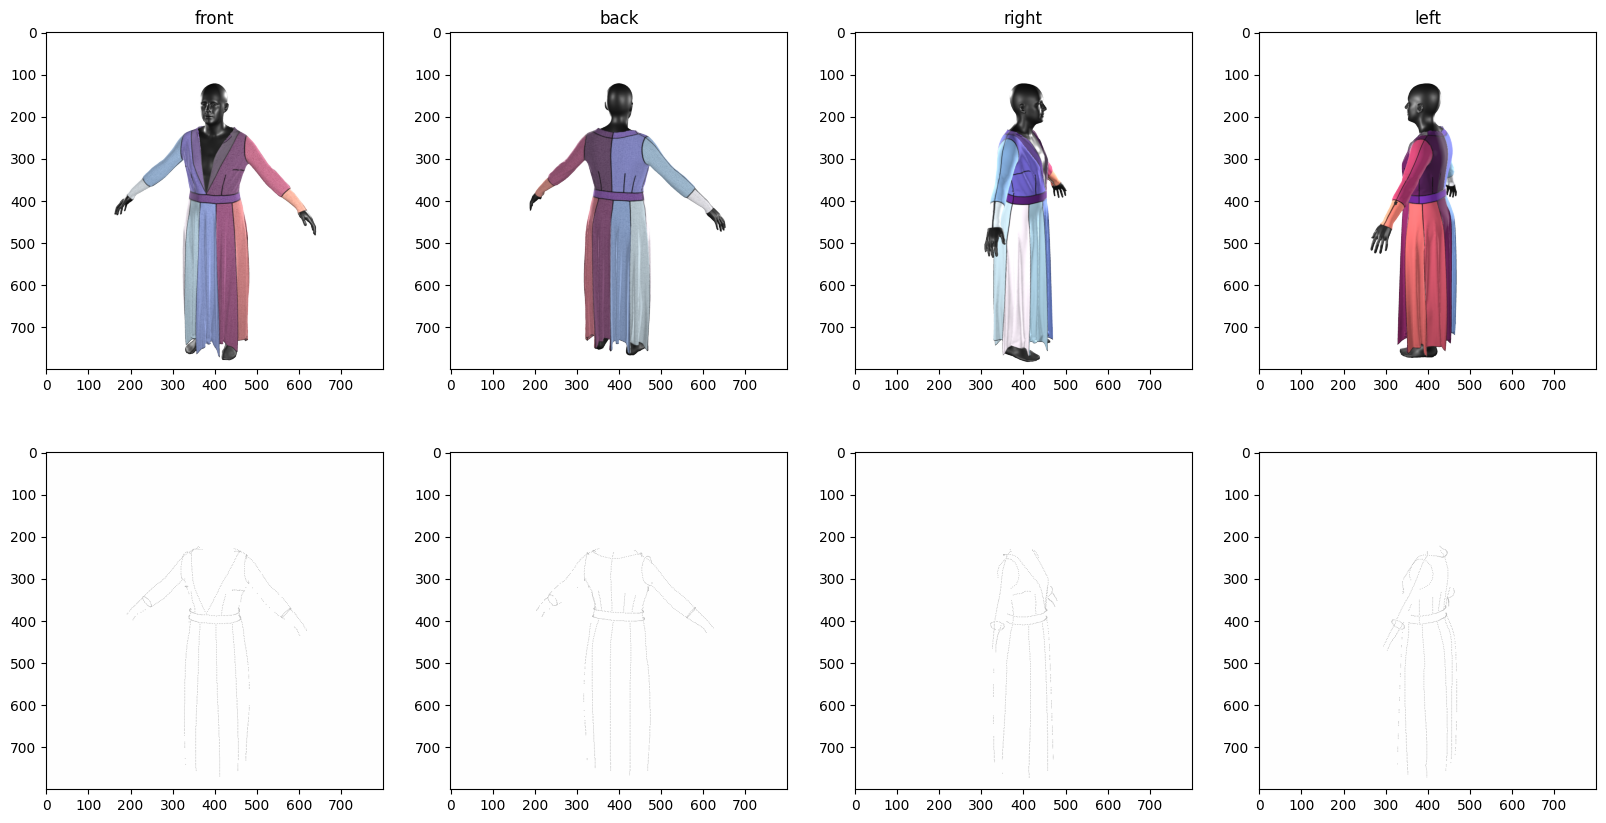

In [9]:
IDX = 0
# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

garment_path_list = sorted(list(filter(
    os.path.isdir,
    glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))
)))

GARMENT_IDX_TO_VIS = list(range(1, 400, 50))


GARMEN_PATH_LIST_TO_VIS = [
    "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J",
]

for garment_path in GARMEN_PATH_LIST_TO_VIS:
    
    garment_id = os.path.basename(garment_path)
    
    # SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json"
    
    # pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

    # panel_svg_path_dict = {
    #     panel_name : pattern._draw_a_panel(
    #         panel_name, apply_transform=False, fill=True
    #     )
    #     for panel_name in pattern.panel_order()
    # }
    # stitch_dict = {
    #     i : v for i, v in enumerate(pattern.pattern['stitches'])
    # }

    rendered_image_list = list(map(
        lambda x : Image.open(os.path.join(garment_path, f"{garment_id}_render_{x}.png")),
        render_props["sides"]
    ))

    VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH = os.path.join(
        garment_path, "visible_seam_vertex_position_dict.pkl"
    )
    visible_seam_vertices_dict = pickle.load(open(VISIBLE_SEAM_VERTEX_POSITION_DICT_PATH, "rb"))


    vis_image_list = [
        np.ones_like(rendered_image_list[i], dtype=np.uint8) for i in range(len(render_props["sides"]))
    ]

    for stitch_idx, visible_info in visible_seam_vertices_dict.items():
        
        for side_idx, side in enumerate(render_props["sides"]):
            if visible_info[side] is not None and len(visible_info[side]) > 0:    
                vis_image_list[side_idx][
                    np.array(visible_info[side])[:, 1],
                    np.array(visible_info[side])[:, 0]
                ] = 255


    FIG_LEN = 5
    NCOLS = len(render_props["sides"])
    NROWS = 2
    plt.figure(figsize=(FIG_LEN * NCOLS, FIG_LEN * NROWS))
    for i, (image, vis_image) in enumerate(zip(rendered_image_list, vis_image_list)):
        plt.subplot(NROWS, NCOLS, i + 1)
        plt.title(
            f"{render_props['sides'][i]}"
        )
        plt.imshow(image)
        
        plt.subplot(NROWS, NCOLS, i + 1 + NCOLS)
        plt.imshow(vis_image)
    
    plt.show()